# Crop Type Classification: CART

Our aim in this notebook is to classify crop type using PlanetScope 4-band Orthotiles. The crop types of particular interest are corn and soybeans.

[CART](http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) is a decision tree algorithm that has shown great promise for classification of remotely sensed imagery. We will use this algorithm to classify crop type.

In this notebook, we will focus on using the PlanetScope imagery 4 bands as well as NDVI calculation as the features that are fed into the CART algorithm. We will train on one PS Orthotile and validate on another PS Orthotile.

### Outline
1. Identify datasets (PS Orthotiles and gold standard dataset for train and test)
1. Train classifier
1. Test classifier


### Gold Standard Dataset

The [USDA 2016 Crop Data Layer](https://www.nass.usda.gov/Research_and_Science/Cropland/Release/index.php) (CDL) provides a national crop type dataset. This dataset was build using Landsat 8, DMC Deimos-1, and UK 2 satellite imagery ([src](https://www.nass.usda.gov/Research_and_Science/Cropland/sarsfaqs2.php#Section3_17.0)), using supervised classification (decision trees) based on ground truth from the Farm Service Agency (FSA) Common Land Unit (CLU) Program. Since this is a derived dataset, it isn't a ground truth dataset but it is known to be quite accurate so can be used as our gold standard dataset. This dataset is provided as a georegistered raster (geoTIFF).

Since corn and soybeans are the primary crops grown in Iowa, we will focus our analysis in that state. The [metadata](https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_ia16.htm) provided for the Iowa 2016 CDL indicates that it's accuracy is 96.4% and that corn (categorization code 1) and soybeans (categorization code 5) are indeed the primary crop types in the state.

### Growth Season

[Iowa 1997 statistics](https://usda.mannlib.cornell.edu/usda/nass/planting/uph97.pdf): corn planting ended June 3, harvesting began Sept 17 and soybean planting ended June 17 and harvesting began Sept 21. Therefore, imagery should be limited to between June 3 and Sept 17, 2016.


## Install Dependencies

In [1]:
from collections import namedtuple
import os
from subprocess import check_output, STDOUT, CalledProcessError
import tempfile
from xml.dom import minidom

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

## Identify Datasets

### PS Orthotoile

Get a PS Orthotile that has majority coverage over the grid, is from a SSO satellite, is free from clouds, and was taken between June 3 and Sept 17, 2016.

Using [planet explorer](https://www.planet.com/explorer/), [210879_1558814_2016-07-25_0e16](https://api.planet.com/data/v1/item-types/PSOrthoTile/items/210879_1558814_2016-07-25_0e16/thumb) was identified as a good candidate.

#### Download Scene and Supporting Files

In [7]:
# uncomment below to learn more about PSOrthotile 210879_1558814_2016-07-25_0e16

# !planet data search --item-type PSOrthoTile --string-in id 210879_1558814_2016-07-25_0e16

In [8]:
# uncomment below to download scene and supporting files to local folder

# !mkdir -p data/cart/210879_1558814_2016-07-25_0e16
# !planet data download --item-type PSOrthoTile --dest data/cart/210879_1558814_2016-07-25_0e16 \
#     --asset-type analytic,analytic_xml,udm --string-in id 210879_1558814_2016-07-25_0e16
# !ls -l --block-size=M data/cart/210879_1558814_2016-07-25_0e16/

In [9]:
# define data file filenames and ensure they exist
train_folder = os.path.join('data', 'cart', '210879_1558814_2016-07-25_0e16')

train_files = {
    'scene': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_Analytic.tif'),
    'metadata': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_Analytic_metadata.xml'),
    'udm': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif'),
}

for filename in train_files.values():
    print(filename)
    assert os.path.isfile(filename)

data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif
data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_Analytic.tif
data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_Analytic_metadata.xml


### 2016 Iowa CDL

Crop type information is provided for Iowa for 2016 from the [USDA 2016 Crop Data Layer](https://www.nass.usda.gov/Research_and_Science/Cropland/Release/index.php) (CDL). We are specifically interested in the CDL for Iowa.

The [metadata](https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_ia16.htm) for the Iowa CDL provides the conversion between tif class values and crop type. The values along with the number of pixels associated with those values can be found in the Data_Quality_Information section of the metadata. The value for corn is 1 and the value for soybeans is 5. Note that there are some values associated with double crops that include corn or soybeans but the pixel count for those categories is zero so they can be disregarded.

In this section, we prepare the Iowa CDL tif for processing, load a block of the tif that matches the block loaded from the PS Orthotile, and then look at the unique values present in the block.

#### Obtain and Prepare Data File

In this section, we download the 2016 Iowa CDL and crop it to the PS Orthotile footprint.

2016 CDL for Iowa is obtained through the [CropScape](https://nassgeodata.gmu.edu/CropScape/) site. On that site, ensure the layer is 'CropLand Data Layers -> 2016', then click the icon for 'Define Area of Interest by State...' (looks like an outline of the US with the US flag design). Under 'Select a State', select Iowa and click 'Submit.' Next, click the icon for 'Download Defined Area of Interest Data.' In the popup, ensure the 'CDL' tab is open and '2016' is selected, then click 'Select.' Another popup should appear with 'Please Wait...' then after a while, the popup should be replaced by a popup that says 'Download files from server'. Click 'Download' and after a bit the download should begin.

Unzip the downloaded folder and move the tif, `CDL_2016_19.tif` to the data folder.

In [10]:
# ensure the tif file is present
cdl_full = os.path.join('data', 'CDL_2016_19.tif')
print(cdl_full)
assert os.path.isfile(cdl_full)

data/CDL_2016_19.tif


#### Crop and Project CDL

We project, resample, and crop the CDL to match the Orthotile and save in train dataset.

In [11]:
# Utility functions: crop, resample, and project an image

# These use gdalwarp. for a description of gdalwarp command line options, see:
# http://www.gdal.org/gdalwarp.html

def gdalwarp_project_options(src_crs, dst_crs):
    src_proj = _crs_to_string(src_crs)
    dst_proj = _crs_to_string(dst_crs)
    return ['-s_srs', src_crs.to_string(), '-t_srs', dst_crs.to_string()]

def gdalwarp_crop_options(bounds, crs):
    xmin, ymin, xmax, ymax = [str(b) for b in bounds]
    dst_proj = _crs_to_string(crs)
    # -te xmin ymin xmax ymax
    return ['-te', xmin, ymin, xmax, ymax]

def gdalwarp_resample_options(width, height, technique='near'):
    # for technique options, see: http://www.gdal.org/gdalwarp.html
    return ['-ts', width, height, '-r', technique]

def gdalwarp(input_filename, output_filename, options):
    commands = _gdalwarp_commands(input_filename, output_filename, options)

    # print error if one is encountered
    # https://stackoverflow.com/questions/29580663/save-error-message-of-subprocess-command
    try:
        output = check_output(commands, stderr=STDOUT)
    except CalledProcessError as exc:
        print(exc.output)

def _gdalwarp_commands(input_filename, output_filename, options):
    commands = ['gdalwarp'] + options + \
               ['-overwrite',
                input_filename,
                output_filename]
    print(' '.join(commands))
    return commands

def _test():
    TEST_DST_SCENE = train_files['scene']
    TEST_SRC_SCENE = cdl_full

    with rasterio.open(TEST_DST_SCENE, 'r') as dst:
        with rasterio.open(TEST_SRC_SCENE, 'r') as src:
            print(_gdalwarp_project_options(src.crs, dst.crs))

            print(_gdalwarp_crop_options(dst.bounds, dst.crs))

            print(_gdalwarp_resample_options(dst.width, dst.height))
# _test()

In [12]:
def prepare_cdl_image(cdl_filename, dst_filename, out_filename):
    '''Project, crop, and resample cdl image to match dst_filename image.'''
    
    with rasterio.open(cdl_filename, 'r') as src:
        with rasterio.open(dst_filename, 'r') as dst:
            # project
            src_crs = _add_nad_datum(src.crs) # Manually add NAD83 datum
            proj_options = _gdalwarp_project_options(src_crs, dst.crs)

            # crop
            crop_options = _gdalwarp_crop_options(dst.bounds, dst.crs)

            # resample
            width, height = dst.shape
            resample_options = _gdalwarp_resample_options(str(width), str(height), 'near')

            options = proj_options + crop_options + resample_options
            
            # run gdalwarp
            gdalwarp(cdl_filename, out_filename, options)

def _add_nad_datum(crs):
    '''Rasterio is not reading the datum for the CDL image so add it manually'''
    crs.update({'datum': 'NAD83'})
    return crs

def _test(delete=True):
    TEST_DST_SCENE = train_files['scene']
    TEST_SRC_SCENE = cdl_full
    
    with tempfile.NamedTemporaryFile(suffix='.tif', delete=delete, dir='.') as out_file:
        # create output
        prepare_cdl_image(TEST_SRC_SCENE, TEST_DST_SCENE, out_file.name)

        # check output
        with rasterio.open(TEST_DST_SCENE, 'r') as dst:
            with rasterio.open(out_file.name, 'r') as src:
                assert dst.crs == src.crs, '{} != {}'.format(src.crs, dst.crs)
                assert dst.bounds == src.bounds
                assert dst.shape == src.shape
# _test()

In [13]:
# create train dataset gold image from CDL image
prep_filename = os.path.join(train_folder, 'CDL_2016_19_prep.tif')

# only generate output if it doesn't already exist
if not os.path.isfile(prep_filename):
    prepare_cdl_image(cdl_full, train_files['scene'], prep_filename)
    
train_files['gold'] = prep_filename
print(train_files['gold'])

data/cart/210879_1558814_2016-07-25_0e16/CDL_2016_19_prep.tif


## Train Classifier

### PS Orthotile to features

In this section we generate classification features from the 4 bands of the PS Orthotile and NDVI calculated from the Orthotile.

In [60]:
# Utility function for working with large images and memory limitations

def _read_window(filename, window):
    with rasterio.open(filename, 'r') as src:
        return src.read(window=window)

def decimated(arry, num=8):
    return arry[::num, ::num].copy()

#### Convert UDM to mask

We convert the UDM file to a boolean mask that can be used to generate masked band arrays

In [ ]:
import matplotlib.colors as colors

from collections import OrderedDict

In [187]:
# Utility functions: visualizing a classified band

def plot_classified_band(class_band, class_labels=None, cmap='rainbow',
                         title='Class Labels', figdim=10):
    fig = plt.figure(figsize=(figdim, figdim))
    ax = fig.add_subplot(1, 1, 1)
    imshow_class_band(ax, class_band, class_labels, cmap=cmap)
    ax.set_title(title)
    ax.set_axis_off()

def imshow_class_band(ax, class_band, class_labels=None, cmap='rainbow'):
    """Show classified band with colormap normalization and color legend. Alters ax in place.
    
    possible cmaps ref: https://matplotlib.org/examples/color/colormaps_reference.html
    """
    class_norm = _ClassNormalize(class_band)
    im = ax.imshow(class_band, cmap=cmap, norm=class_norm)

    try:
        # add class label legend
        # https://stackoverflow.com/questions/25482876
        # /how-to-add-legend-to-imshow-in-matplotlib
        color_mapping = class_norm.get_mapping()
        colors = [im.cmap(color_mapping[k]) for k in class_labels.keys()]
        labels = class_labels.values()

        # https://matplotlib.org/users/legend_guide.html
        # tag: #creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
        patches = [mpatches.Patch(color=c, label=l) for c,l in zip(colors, labels)]

        ax.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.)
    except AttributeError:
        # class_labels not specified
        pass

# https://matplotlib.org/users/colormapnorms.html
class _ClassNormalize(colors.Normalize):
    def __init__(self, arry):
        # get unique unmasked values
        values = [v for v in np.unique(arry)
                  if not isinstance(v, np.ma.core.MaskedConstant)]

        color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)
        self.mapping = dict((v, ct)
                            for v, ct in zip(values, color_ticks))
        
        # Initialize base Normalize instance
        vmin = 0
        vmax = 1
        clip = False
        colors.Normalize.__init__(self, vmin, vmax, clip)
    
    def __call__(self, arry, clip=None):
        return self._map(arry)
    
    def _map(self, arry):
        new_arry = arry.copy().astype(np.float)
        for k, v in self.mapping.items():
            new_arry[arry==k] = v
        return new_arry
    
    def get_mapping(self):
        return self.mapping

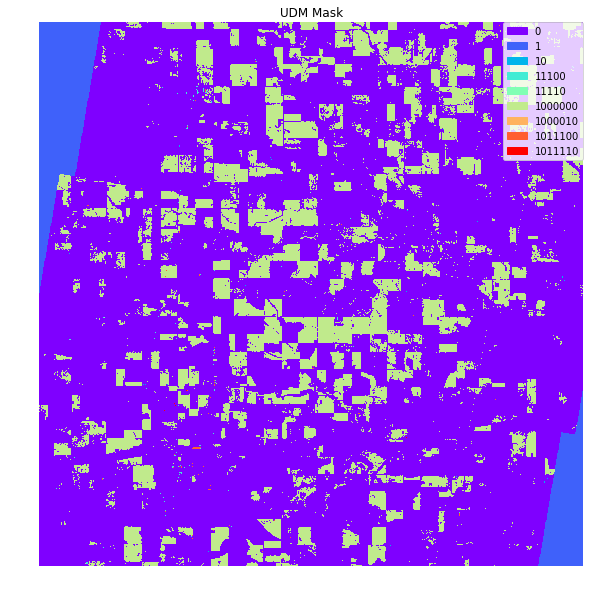

In [189]:
def load_udm(udm_filename, window=None):
    '''Load bit-encoded UDM as an array.
    
    The description for the information encoded in the bits in the UDM is from:
    https://www.planet.com/docs/spec-sheets/sat-imagery/
    section 7.2
    
    Bit 0: blackfill
    Bit 1: cloud covered
    Bit 2: missing or suspect data in Blue band
    Bit 3: missing or suspect data in Green band
    Bit 4: missing or suspect data in Red band
    Bit 6: missing or suspect data in NIR band

    Pixels with no issues have all bits set to 0, therefore their values are zero.    
    '''    
    return _read_window(udm_filename, window)[0,...]

def get_udm_labels(udm):
    return OrderedDict((v, '{0:b}'.format(v)) for v in np.unique(udm))

        
def _test():
    udm = load_udm(train_files['udm'])
    udm_labels = get_udm_labels(udm)
    plot_classified_band(decimated(udm), class_labels=udm_labels, title='UDM Mask')
_test()

It looks like there are quite a few regions (they look like crops) where there is an issue in the NIR band. Likely this is due to saturation in the band.

The next step in loading the UDM is to convert it to a Boolean mask for application to the image bands.

In [191]:
def udm_to_mask(udm_array):
    '''Mask all pixels with any issues.'''
    return udm_array != 0

def _test():
    mask = udm_to_mask(load_udm(train_files['udm']))
    print'{}/{} ({:0.0f}%) masked'.format(mask.sum(), mask.size,
                                          (100.0 * mask.sum())/mask.size)
_test()

14525797/64000000 (23%) masked


#### Load and Mask Bands

We load the orthotile bands (optionally applying a window) and mask them using the udm mask.

In [162]:
NamedBands = namedtuple('NamedBands', 'b, g, r, nir')

def load_masked_bands(scene_filename, udm_filename, window=None):
    """Loads a 4-band BGRNir Planet Image file as a list of masked bands.
    
    The masked bands share the same mask, so editing one band mask will
    edit them all.
    """
    bands = load_bands(scene_filename, window=window)
    mask = udm_to_mask(load_udm(udm_filename, window=window))
    return NamedBands(*[np.ma.array(b, mask=mask)
                        for b in bands])

def load_bands(filename, window=None):      
    b, g, r, nir = _read_window(filename, window=window)
    return NamedBands(b=b, g=g, r=r, nir=nir)

def get_mask(bands):
    return bands[0].mask


def check_mask(bands):
    band_mask = get_mask(bands)
    return '{}/{} ({:0.0f}%) masked'.format(band_mask.sum(), band_mask.size,
                                            (100.0 * band_mask.sum())/band_mask.size)


def _test():
#     window = ((500,1500),(500,1500))
    window = None
    print(check_mask(load_masked_bands(train_files['scene'],
                                       train_files['udm'],
                                       window=window)))
_test()

14525797/64000000 (23%) masked


#### Convert to Reflectance

The PSOrthotiles provide the top of atmosphere radiance values for each band. It is preferred to work with top of atmosphere reflectance, as this is more consistent across time. Therefore, we convert each band to reflectance.

In [163]:
# Utility functions: converting an image to reflectance

NamedCoefficients = namedtuple('NamedCoefficients', 'b, g, r, nir')

def read_refl_coefficients(metadata_filename):
    # https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/ndvi/ndvi_planetscope.ipynb
    xmldoc = minidom.parse(metadata_filename)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
    return NamedCoefficients(b=coeffs[1],
                             g=coeffs[2],
                             r=coeffs[3],
                             nir=coeffs[4])

def _apply_coeffs(bands, coeffs):
    return NamedBands(*[b.astype(float)*c for b,c in zip(bands, coeffs)])


def _test():
    print(read_refl_coefficients(train_files['metadata']))
# _test()

In [164]:
def load_reflectance_bands(scene_file, udm_file, metadata_file, window=None):
    return _to_reflectance(load_masked_bands(scene_file, udm_file, window=window),
                                metadata_file)

def _to_reflectance(bands, metadata_filename):
    coeffs = read_refl_coefficients(metadata_filename)
    return _apply_coeffs(bands, coeffs)

def _test():
#     window = ((500,1500),(500,1500))
    window = None
    bands = load_reflectance_bands(train_files['scene'],
                                   train_files['udm'],
                                   train_files['metadata'],
                                   window=window)
    print([b.mean() for b in bands])
# _test()

#### Display Image

To ensure everything loaded correctly, we display the image with and without the mask converted to the alpha channel.

In [165]:
# Utility functions: displaying an image

def _linear_scale(ndarray, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray - old_min) * (new_max - new_min) / (old_max - old_min) + new_min
# print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))

def _mask_to_alpha(bands):
    band = np.atleast_3d(bands[0])
    alpha = np.zeros_like(band)
    alpha[~band.mask] = 1
    return alpha

def _add_alpha_mask(bands):
    return np.dstack([bands, _mask_to_alpha(bands)])

def scale_bands(band_stack):
    old_min = np.percentile(band_stack, 2)
    old_max = np.percentile(band_stack, 98)
    old_min = band_stack.min()
    old_max = band_stack.max()

    new_min = 0
    new_max = 1
    scaled = [np.clip(_linear_scale(b.astype(np.float),
                                    old_min, old_max,
                                    new_min, new_max),
                      new_min, new_max)
              for b in bands]
    return scaled

def bands_min(bands):
#     old_min = min([b.min() for b in bands])
    old_min = np.percentile(np.concatenate([b.compressed() for b in bands]), 2)
    return old_min

def bands_max(bands):
#     old_max = max([b.max() for b in bands])
    old_max = np.percentile(np.concatenate([b.compressed() for b in bands]), 98)
    return old_max


def bands_to_display(bands, alpha=False):
    """Converts a list of 3 bands to a 3-band rgb, normalized array for display."""  
    assert len(bands) in [3]

    old_min = bands_min(bands)
    old_max = bands_max(bands)
#     print('old min: {}, old max: {}'.format(old_min, old_max))

    new_min = 0
    new_max = 1
    scaled = [np.clip(_linear_scale(b.astype(np.float),
                                    old_min, old_max,
                                    new_min, new_max),
                      new_min, new_max)
              for b in bands]

    filled = [b.filled(fill_value=new_min) for b in scaled]
    if alpha:
        filled.append(_mask_to_alpha(scaled))

    return np.dstack(filled)

14525797/64000000 (23%) masked
(0.06735662417351039, 0.43147524014914557)
(0.057844202364870402, 0.4222778367325376)
(0.034907943462311498, 0.4360231637032943)
(0.066104635970321998, 0.58677885799014595)


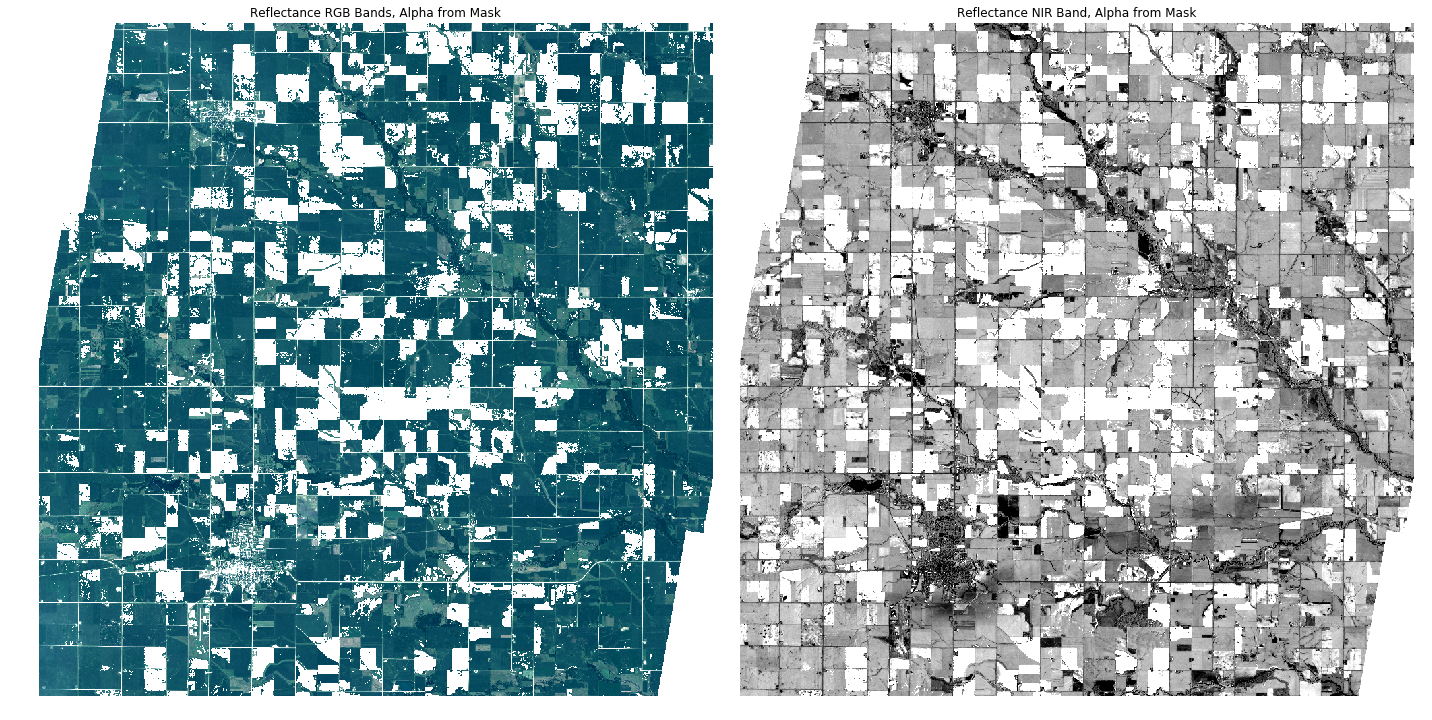

In [166]:
def show_bands(bands):
    fig, axes = plt.subplots(nrows=1, ncols=2,
                                   sharex=True, sharey=True,
                                   figsize=(20,10))
    for ax in axes.ravel():
        ax.set_adjustable('box-forced')
        ax.set_axis_off()

    ax2, ax4 = axes
    ax2.imshow(decimated(bands_to_display([bands.r, bands.g, bands.b], alpha=True)))
    ax2.set_title('Reflectance RGB Bands, Alpha from Mask')

    ax4.imshow(decimated(bands_to_display(3*[bands.nir], alpha=True)))
    ax4.set_title('Reflectance NIR Band, Alpha from Mask')
    plt.tight_layout()

def _test():
    window = None
    refl_bands = load_reflectance_bands(train_files['scene'],
                                        train_files['udm'],
                                        train_files['metadata'],
                                        window=window)
    print(check_mask(refl_bands))
    for b in refl_bands:
        print (b.min(), b.max()) 
    show_bands(refl_bands)
_test()

#### Features from Image

We calculate the classification features from the scene and convert them to an array for feeding into the CART classifier.

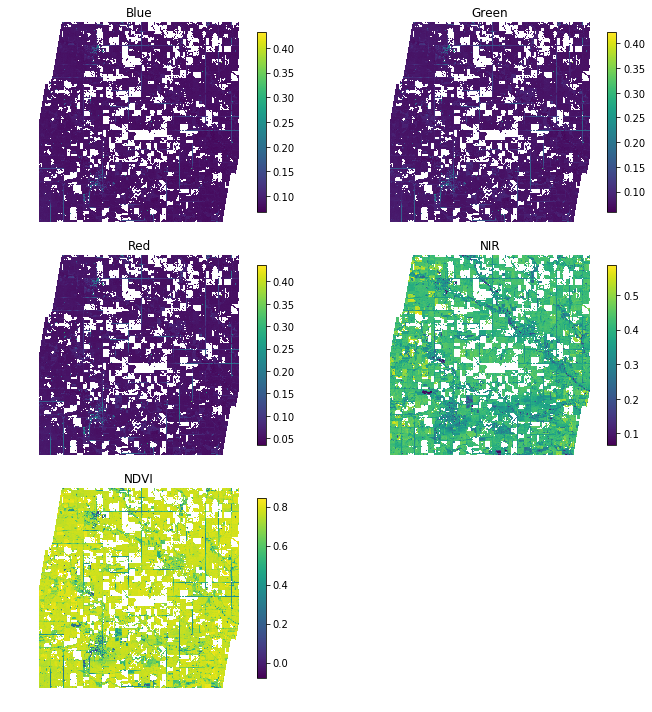

In [167]:
def calculate_ndvi(bands):
    ndvi = (bands.nir.astype(np.float) - bands.r) / (bands.nir + bands.r)
    return ndvi


def build_feature_bands(bands):
    """Prepare bands representing pixel features and provide feature names.
    
    Takes as input NamedBands
    Returns (1) tuple of bands representing features and (2) feature names
    """
    # not copying these bands to minimize memory footprints
    features = (bands.b, bands.g, bands.r, bands.nir, calculate_ndvi(bands))
    feature_names = ('Blue', 'Green', 'Red', 'NIR', 'NDVI')
    return features, feature_names


def display_feature_bands(bands, names):
    # for this notebook, we know there are 4 features and we will use that
    # knowledge to side-step some logic in organizing subplots
    assert len(bands) == 5 
    
    fig, subplot_axes = plt.subplots(nrows=3, ncols=2,
                                     sharex=True, sharey=True,
                                     figsize=(10,10))
    axes = subplot_axes.flat[:-1]
    delaxis = subplot_axes.flat[-1]
    fig.delaxes(delaxis)
    for ax, band, name in zip(axes, bands, names):
        ax.set_adjustable('box-forced')
        ax.axis('off')

        pcm = ax.imshow(band, alpha=True)
        ax.set_title(name)
        fig.colorbar(pcm, ax=ax,
                     pad=0.05, shrink=0.9)

    plt.tight_layout()

def _test():
#     window = ((500,1500),(500,1500))
    window = None
    refl_bands = load_reflectance_bands(train_files['scene'],
                                        train_files['udm'],
                                        train_files['metadata'],
                                        window=None)
    feat_bands, feat_names = build_feature_bands(refl_bands)
    display_feature_bands(feat_bands, feat_names)
_test()

From the scales on the colorbars, we see that the scales of the features are not all the same. Max for the spectral band features is ~0.35 while NDVI feature max is ~0.9. This is not a problem for decision trees, which do not require that features be normalized before training.

In [168]:
def to_X(feature_bands):
    """Convert feature_bands (tuple of bands) to 2d array for working with classifier.
    """
    return np.stack([f.compressed() for f in feature_bands], # exclude masked pixels
                     axis=1)


def _test():
    refl_bands = load_reflectance_bands(train_files['scene'],
                                        train_files['udm'],
                                        train_files['metadata'],
                                        window=((500,1500),(500,1500)))
    feat_bands, feat_names = build_feature_bands(refl_bands)
    
    X = to_X(feat_bands)
    print(X.shape)
_test()

(754234, 5)


### Gold Standard Dataset to Labels

#### Load and Visualize Gold Classified Band

Filter to corn and soybean classes and visualize the classified band.

In [169]:
# class labels from metadata
CLASS_LABELS = {1: 'corn', 5: 'soybeans'}

In [170]:
def load_gold_class_band(gold_filename, class_labels=None, window=None, fill_value=0):
    gold_class_band = _read_window(gold_filename, window)[0,...]
    
    try:
        # mask pixels with a value not in class_labels
        masks = [gold_class_band == val for val in class_labels.keys()]
        mask = np.any(np.dstack(masks), axis=2)
        mask = ~mask
        
        masked_band = np.ma.array(np.ma.array(gold_class_band, mask=mask).filled(fill_value=fill_value),
                                  mask=mask)
    except AttributeError:
        # mask nothing
        null_mask = np.zeros(gold_class_band.shape, dtype=np.bool)
        masked_band = np.ma.array(gold_class_band, mask=null_mask)

    return masked_band

def _test():
    print np.unique(load_gold_class_band(train_files['gold']))
    print np.unique(load_gold_class_band(train_files['gold'], class_labels=CLASS_LABELS))
_test()

[1 5 27 28 36 37 61 111 121 122 123 124 131 141 142 152 176 190 195]
[1 5 --]


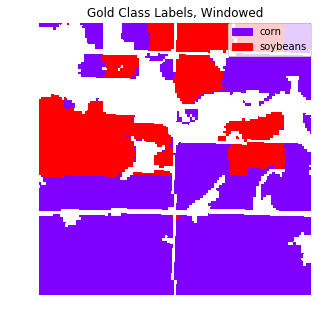

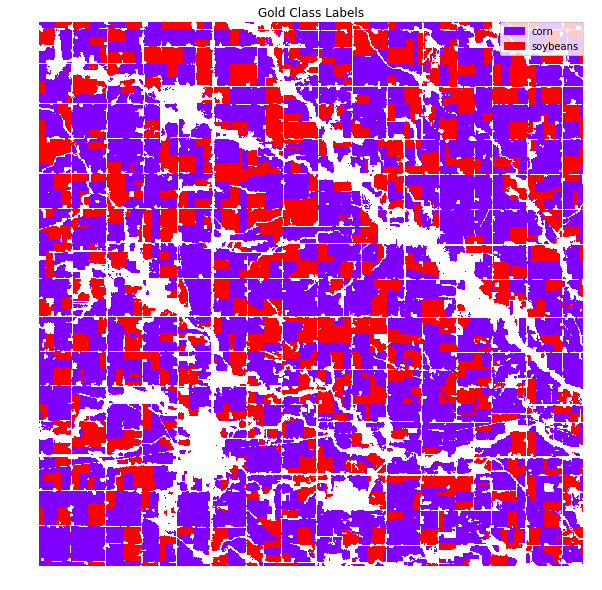

In [194]:
def _test():
    plot_classified_band(load_gold_class_band(train_files['gold'],
                                              class_labels=CLASS_LABELS,
                                              window=((500,1500),(500,1500))),
                         class_labels=CLASS_LABELS, title='Gold Class Labels, Windowed', figdim=5)

    plot_classified_band(decimated(load_gold_class_band(train_files['gold'], class_labels=CLASS_LABELS)),
                         class_labels=CLASS_LABELS, title='Gold Class Labels')
_test()

In [195]:
def to_y(classified_band):
    return classified_band.compressed()

def _test():
    print(to_y(load_gold_class_band(train_files['gold'], class_labels=CLASS_LABELS)).shape)
_test()

(49793076,)


### Train the Classifier

Right now we are just going to train the classifier with a subset of data from the Orthotile (the window we have been working with thus far) and use the dummy label data generated above. The goal is to ensure we can run through training and predicting with the classifier and end up with a classified band that looks like the original in shape/mask and shows the classes as labeled above.

In [196]:
# window = ((500,1500),(500,1500))
window = None
# window = ((0,2000),(0,2000))
# window = ((0,4000),(0,4000))

In [197]:
refl_bands = load_reflectance_bands(train_files['scene'],
                                    train_files['udm'],
                                    train_files['metadata'],
                                    window=window)
feat_bands, _ = build_feature_bands(refl_bands)
X = to_X(refl_bands)
print(X.shape)

(49474203, 4)


In [198]:
gold_class_band = load_gold_class_band(train_files['gold'], class_labels=CLASS_LABELS, window=window)
gold_class_band.mask = get_mask(feat_bands)
y = to_y(gold_class_band)
print(y.shape)

(49474203,)


Unconstrained, decision trees overfit the training data. Therefore, we must constrain the decision tree by setting a hyperparameter. For now, we will just blindly set the `max_depth` hyperparameter. Eventually, it would be ideal to use cross-validation to identify the best hyperparameter values.

In [199]:
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

Check to see what classes are predicted

In [200]:
y_pred = clf.predict(X)
print(np.unique(y_pred))

[0 1 5]


In [201]:
def classified_band_from_y(y, band_mask):
    class_band = np.ma.array(np.zeros(band_mask.shape),
                             mask=band_mask.copy())
    class_band[~class_band.mask] = y
    return class_band

pred_band = classified_band_from_y(y_pred, get_mask(refl_bands))

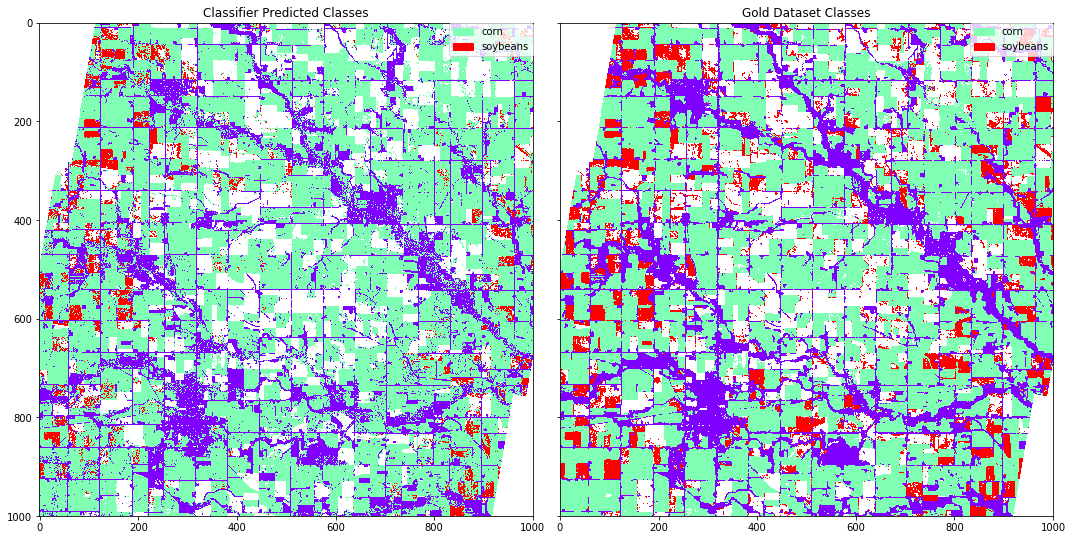

In [203]:
def plot_predicted_vs_truth(predicted_class_band, gold_class_band, class_labels=None, figsize=(15,15)):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                   sharex=True, sharey=True,
                                   figsize=figsize)
    for ax in (ax1, ax2):
        ax.set_adjustable('box-forced')

    imshow_class_band(ax1, decimated(predicted_class_band), class_labels=class_labels)
    ax1.set_title('Classifier Predicted Classes')

    imshow_class_band(ax2, decimated(gold_class_band), class_labels=class_labels)
    ax2.set_title('Gold Dataset Classes')
    plt.tight_layout()
    
plot_predicted_vs_truth(pred_band, gold_class_band,class_labels=CLASS_LABELS)

Alright! This looks promising. The predicted classes just look like a higher-resolution version of the gold dataset classes. This makes sense, the gold dataset image was upsampled from 30m to 3m (the PS Orthotile pixel size) using nearest-neighbor so would not have the detail to match a prediction performed on the PS Orthotile resolution.